In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spotify-songs-and-artists-dataset/spotifydataset.csv


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load data
df = pd.read_csv('/kaggle/input/spotify-songs-and-artists-dataset/spotifydataset.csv')
df.head()

,Unnamed: 0,artist_name,genres,followers,artist_popularity,artist_url,track_name,album_name,release_date,duration_ms,...,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0,Ariana Grande,pop,98934105,89,https://open.spotify.com/artist/66CXWjxzNUsdJx...,we can't be friends (wait for your love),eternal sunshine,2024-03-08,228639,...,0.646,5,-8.334,1,0.0427,0.0615,0.000030,0.0740,0.295,115.842
1,1,Ariana Grande,pop,98934105,85,https://open.spotify.com/artist/66CXWjxzNUsdJx...,the boy is mine,eternal sunshine,2024-03-08,173639,...,0.630,7,-5.854,0,0.0434,0.1570,0.000000,0.0732,0.447,97.998
2,2,Ariana Grande,pop,98934105,83,https://open.spotify.com/artist/66CXWjxzNUsdJx...,intro (end of the world),eternal sunshine,2024-03-08,92400,...,0.362,10,-9.480,1,0.0416,0.6700,0.000000,0.1760,0.385,84.726
3,3,Ariana Grande,pop,98934105,80,https://open.spotify.com/artist/66CXWjxzNUsdJx...,Save Your Tears (Remix) (with Ariana Grande) -...,After Hours (Deluxe),2020-03-20,191013,...,0.825,0,-4.645,1,0.0325,0.0215,0.000024,0.0936,0.593,118.091
4,4,Ariana Grande,pop,98934105,79,https://open.spotify.com/artist/66CXWjxzNUsdJx...,"yes, and?",eternal sunshine,2024-03-08,214994,...,0.775,1,-6.614,1,0.0548,0.1900,0.000065,0.1130,0.787,118.998


## 1. EDA

In [4]:
# Basic info
print("Dataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         1000 non-null   int64  
 1   artist_name        1000 non-null   object 
 2   genres             837 non-null    object 
 3   followers          1000 non-null   int64  
 4   artist_popularity  1000 non-null   int64  
 5   artist_url         1000 non-null   object 
 6   track_name         1000 non-null   object 
 7   album_name         1000 non-null   object 
 8   release_date       1000 non-null   object 
 9   duration_ms        1000 non-null   int64  
 10  explicit           1000 non-null   bool   
 11  track_popularity   1000 non-null   int64  
 12  danceability       1000 non-null   float64
 13  energy             1000 non-null   float64
 14  key                1000 non-null   int64  
 15  loudness           1000 non-null   float64
 16  mode       

In [5]:
# Statistical summary of numerical features
print("\nStatistical Summary:")
print(df.describe())


Statistical Summary:
        Unnamed: 0     followers  artist_popularity    duration_ms  \
count  1000.000000  1.000000e+03        1000.000000    1000.000000   
mean    499.500000  1.150655e+07          59.429000  212368.619000   
std     288.819436  2.293890e+07          23.884963   65706.472572   
min       0.000000  2.000000e+00           0.000000   51680.000000   
25%     249.750000  1.038784e+06          57.000000  173083.000000   
50%     499.500000  3.923159e+06          67.000000  204382.500000   
75%     749.250000  1.142132e+07          74.000000  244192.750000   
max     999.000000  1.194287e+08          92.000000  707160.000000   

       track_popularity  danceability       energy          key     loudness  \
count       1000.000000   1000.000000  1000.000000  1000.000000  1000.000000   
mean          59.429000      0.611430     0.660562     5.243000    -7.160373   
std           23.884963      0.167246     0.207568     3.613725     4.479642   
min            0.000000    

In [6]:
# Set plot style for consistency
plt.style.use('seaborn')
sns.set_palette('viridis')

In [7]:
# Select numerical audio features and artist metrics
numerical_features = ['followers', 'artist_popularity', 'duration_ms', 'energy', 'key', 
                      'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 
                      'liveness', 'valence', 'tempo']

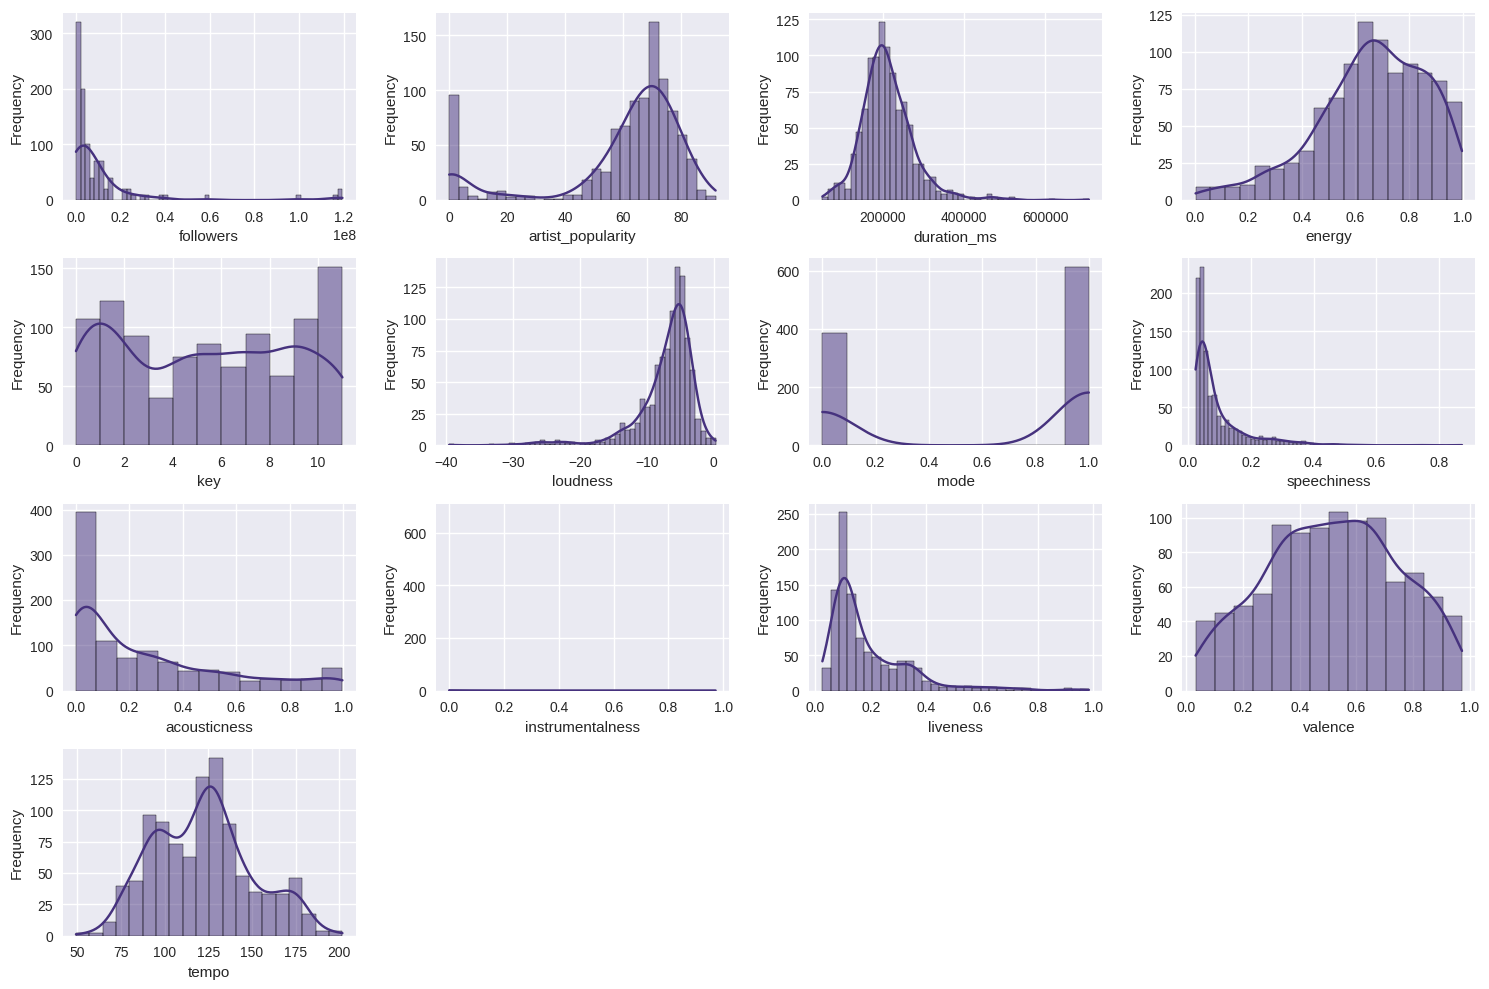

In [8]:
# Distribution plots for numerical features
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(4, 4, i)
    sns.histplot(df[feature], kde=True)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

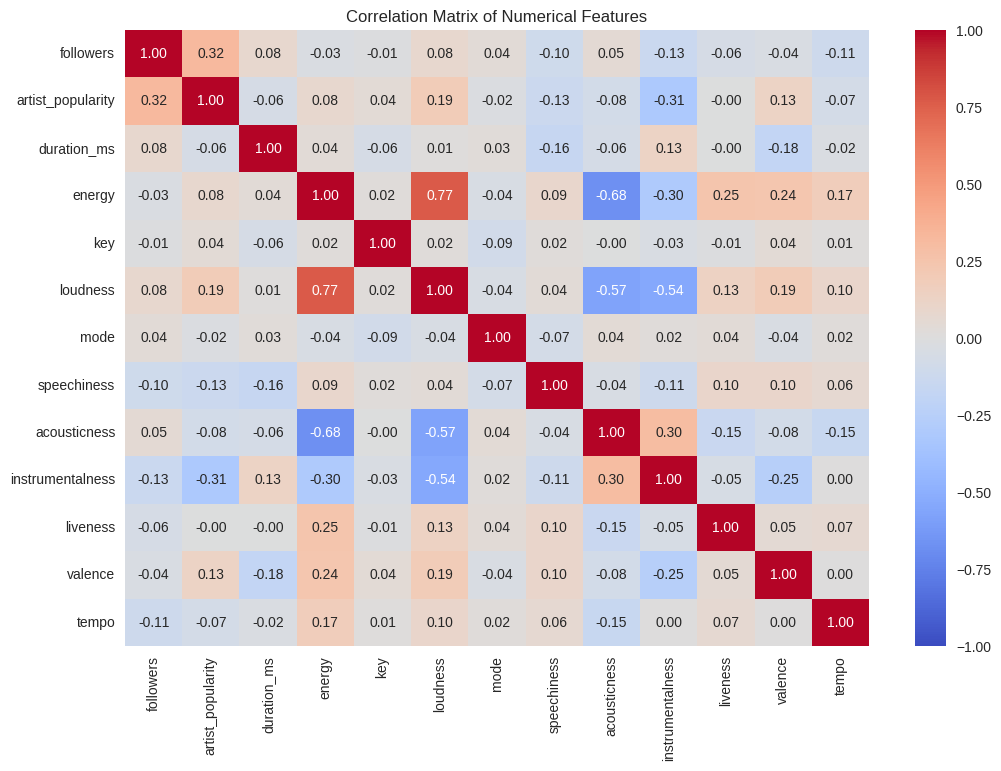

In [9]:
# Correlation matrix
plt.figure(figsize=(12, 8))
corr_matrix = df[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [10]:
# Categorical feature analysis
print("\nUnique Genres:")
print(df['genres'].value_counts())
print("\nUnique Artists:")
print(df['artist_name'].value_counts().head(10))


Unique Genres:
genres
pop                                                                                         40
dance pop, pop                                                                              20
alt z, escape room                                                                          10
electro house, pop nacional, slap house                                                     10
afrobeats                                                                                   10
                                                                                            ..
latin hip hop, reggaeton, trap latino, urbano latino                                        10
modern rock, neon pop punk, pop emo, pop punk                                               10
k-pop, k-pop boy group                                                                      10
atl hip hop, dirty south rap, hip hop, old school atlanta hip hop, rap, southern hip hop    10
social media pop           

In [11]:
# Inspect release_date column to diagnose issues
print("\nSample of release_date values (first 20):")
print(df['release_date'].head(20))
print("\nUnique release_date formats:")
print(df['release_date'].apply(type).value_counts())
print("\nSample of unique release_date values:")
print(df['release_date'].unique()[:20])


Sample of release_date values (first 20):
0     2024-03-08
1     2024-03-08
2     2024-03-08
3     2020-03-20
4     2024-03-08
5     2014-08-22
6     2023-03-14
7     2019-02-08
8     2016-05-20
9     2016-05-20
10    2021-11-19
11    2011-01-24
12    2011-01-24
13    2011-01-24
14    2012-10-04
15    2015-11-20
16    2015-11-20
17    2008-01-28
18    2008-01-28
19    2015-11-20
Name: release_date, dtype: object

Unique release_date formats:
release_date
<class 'str'>    1000
Name: count, dtype: int64

Sample of unique release_date values:
['2024-03-08' '2020-03-20' '2014-08-22' '2023-03-14' '2019-02-08'
 '2016-05-20' '2021-11-19' '2011-01-24' '2012-10-04' '2015-11-20'
 '2008-01-28' '2018-11-20' '2023-08-18' '2018-05-25' '2015-05-26'
 '2024-08-02' '2013' '2023-06-02' '2019-08-23' '2024-04-18']


In [12]:
# Handle release_date with robust year extraction
def extract_year(date_str):
    # Handle non-string inputs
    if not isinstance(date_str, str):
        return np.nan
    # Handle year-only strings (e.g., "2013")
    if date_str.strip().isdigit() and len(date_str.strip()) == 4:
        try:
            return int(date_str.strip())
        except:
            return np.nan
    # Handle other date formats
    try:
        return pd.to_datetime(date_str, format='mixed', errors='coerce').year
    except:
        return np.nan

df['release_year'] = df['release_date'].apply(extract_year)

In [13]:
# Check for missing years after extraction
print("\nMissing Release Years:")
print(df['release_year'].isnull().sum())
print("\nSample of extracted release_year values:")
print(df[['release_date', 'release_year']].head(20))


Missing Release Years:
0

Sample of extracted release_year values:
   release_date  release_year
0    2024-03-08          2024
1    2024-03-08          2024
2    2024-03-08          2024
3    2020-03-20          2020
4    2024-03-08          2024
5    2014-08-22          2014
6    2023-03-14          2023
7    2019-02-08          2019
8    2016-05-20          2016
9    2016-05-20          2016
10   2021-11-19          2021
11   2011-01-24          2011
12   2011-01-24          2011
13   2011-01-24          2011
14   2012-10-04          2012
15   2015-11-20          2015
16   2015-11-20          2015
17   2008-01-28          2008
18   2008-01-28          2008
19   2015-11-20          2015


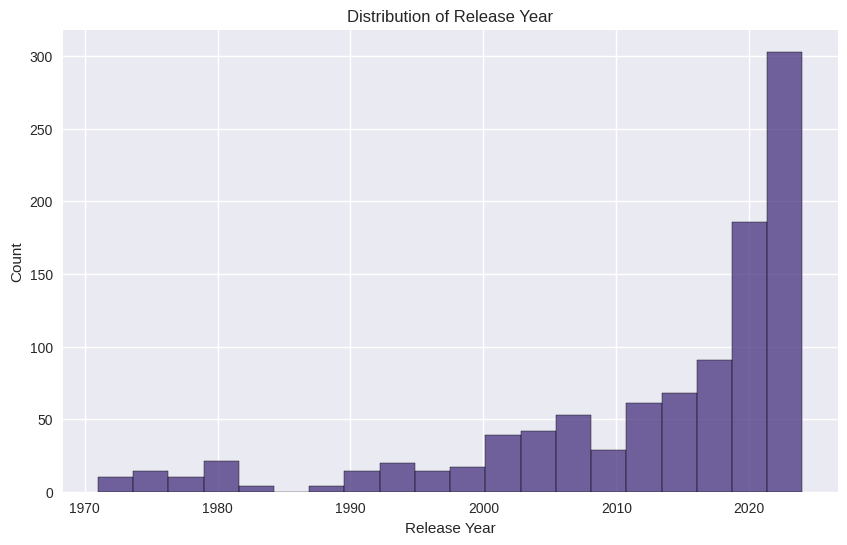

In [15]:
# Release year distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['release_year'].dropna(), bins=20)
plt.title('Distribution of Release Year')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.show()

#### **Analysis of Results**

**1. Missing Values:**

- genres column has 163 missing values (16.3% of entries), which is significant. We’ll need to decide whether to impute these (e.g., with the most frequent genre, “pop”), drop rows, or exclude genres from clustering if not critical.
- No other columns have missing values

**2. Release Date Handling:**

- The release_date column contains strings in mixed formats: full dates (e.g., “2024-03-08”) and year-only (e.g., “2013”).
- All entries are strings, and the extract_year function successfully parsed all values, mapping them to release_year (e.g., “2024-03-08” → 2024, “2013” → 2013).
- The release year distribution shows a right-skewed pattern, with most tracks released after 2000, peaking around 2020–2024. Earlier years (1960–1990) have sparse data, which may influence clustering if release_year is included as a feature.

**3. Numerical Feature Distributions:**

- **followers:** Highly skewed (mean: 1.15e7, max: 1.19e8), with most artists having fewer than 2e7 followers. Log-transformation may be necessary for clustering to reduce the impact of extreme values.
- **artist_popularity:** Right-skewed (mean: 59.43, median: 67), ranging from 0 to 92. Most artists have popularity between 50–80, suggesting a dataset of relatively popular artists.
- **duration_ms:** Slightly right-skewed (mean: 212,368 ms, 3.5 minutes), ranging from 51,680 to 707,160 ms. Most tracks are 150,000–250,000 ms (2.5–4 minutes), typical for pop music.
- **energy:** Left-skewed (mean: 0.66), with most tracks having high energy (0.5–0.9). This aligns with the dominance of pop and dance genres.
- **key:** Discrete values (0–11), with a multimodal distribution. Keys 0, 2, 7, and 9 are more common, reflecting musical preferences in the dataset.
- **loudness:** Left-skewed (mean: -7.16 dB), ranging from -39.48 to 0.273 dB. Most tracks are between -10 and 0 dB, typical for modern music production.
- **mode:** Binary (0 = minor, 1 = major), with 61.3% in major mode (mean: 0.613). suggests a tendency toward brighter, happier tracks.
- **speechiness:** Right-skewed (mean: 0.091), with most values below 0.2. indicates low speech content (typical for music rather than spoken word).
- **acousticness:** Right-skewed (mean: 0.266), with most tracks below 0.4, suggests a preference for non-acoustic, produced sounds.
- **instrumentalness:** Extremely right-skewed (mean: 0.075), with most tracks near 0, indicates vocals dominate (max: 0.972 for rare instrumental tracks).
- **liveness:** Right-skewed (mean: 0.189), with most values below 0.3, suggests most tracks are studio recordings rather than live performances.
- **valence:** Fairly uniform (mean: 0.517), ranging from 0.033 to 0.973, indicating a balanced mix of sad and happy tracks.
- **tempo:** Slightly right-skewed (mean: 122.14 BPM), with most tracks between 100–150 BPM, typical for pop and dance music.

**4. Correlation Matrix:**

- **Strong positive correlations:**
    - **energy and loudness (0.77):** High-energy tracks tend to be louder, which is expected in music production.
    - **energy and valence (0.24):** Energetic tracks are often more positive/happy.
- **Strong negative correlations:**
    - **energy and acousticness (-0.68):** High-energy tracks are less acoustic, aligns with produced pop/dance music.
    - **loudness and acousticness (-0.57):** Louder tracks are less acoustic.
    - **artist_popularity and instrumentalness (-0.31):** More popular artists tend to have less instrumental tracks, favors vocals.
- **Weak correlations:**
    - **followers and artist_popularity (0.32):** Some correlation, but not as strong as expected, indicating popularity metrics may capture different aspects.
    - Most other pairs (e.g., key, mode, tempo) show weak correlations, suggesting independence for clustering.
- **Implications:** Features like energy, loudness, and acousticness may dominate clustering due to their correlations. We may consider dimensionality reduction like PCA if needed.
  
**5. Categorical Features:**

- **genres:** 80 unique genres, with “pop” (40 entries) and “dance pop, pop” (20 entries) being the most common. However, 163 missing values need addressing. Genres are often comma-separated lists (e.g., “latin hip hop, reggaeton”), requiring multi-label encoding if used in clustering.
- **artist_name:** 106 entries for artist “A” (possibly a data issue or placeholder), followed by artists like Ariana Grande (10 entries). High cardinality (many unique artists) suggests grouping or encoding challenges for clustering.

**6. Release Year:**

- Tracks span from 1960 to 2024, with a heavy concentration in recent years (2020–2024). This skew may bias clustering toward modern music trends unless balanced or excluded.

## 2. Preprocessing

In [17]:
# Copy the original dataframe
df_original = df.copy()

In [18]:
# Select features for clustering
features = ['artist_popularity', 'followers', 'danceability', 'energy', 'key', 'loudness', 
            'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
            'valence', 'tempo', 'release_year']
X = df[features].copy()

In [19]:
# Log-transform skewed features
X['followers'] = np.log1p(X['followers'])  # log1p handles zero values
X['instrumentalness'] = np.log1p(X['instrumentalness'])

In [20]:
# Handle any infinite or NaN values after transformation
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.median(), inplace=True)

In [21]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features)

In [22]:
# Verify preprocessing
print("Preprocessed Data (first 5 rows):")
print(X_scaled.head())
print("\nPreprocessed Data Info:")
print(X_scaled.info())
print("\nMissing Values in Preprocessed Data:")
print(X_scaled.isnull().sum())

Preprocessed Data (first 5 rows):
   artist_popularity  followers  danceability    energy       key  loudness  \
0           1.238679    1.08798      0.200823 -0.070192 -0.067277 -0.262122   
1           1.071126    1.08798      1.098154 -0.147313  0.486445  0.291770   
2           0.987349    1.08798     -0.630704 -1.439104  1.317029 -0.518074   
3           0.861684    1.08798      0.230734  0.792609 -1.451583  0.561793   
4           0.819796    1.08798      1.050296  0.551603 -1.174722  0.122029   

       mode  speechiness  acousticness  instrumentalness  liveness   valence  \
0  0.794557    -0.538762     -0.707668         -0.341694 -0.789715 -0.952150   
1 -1.258562    -0.531018     -0.376933         -0.341879 -0.795218 -0.299172   
2  0.794557    -0.550930      1.399684         -0.341879 -0.088114 -0.565518   
3  0.794557    -0.651599     -0.846195         -0.341730 -0.654898  0.328030   
4  0.794557    -0.404905     -0.262648         -0.341481 -0.521456  1.161436   

      temp

## 3. Clustering with K-Means

In [24]:
# Elbow method to find optimal number of clusters
inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    if k > 1:  # Silhouette score requires at least 2 clusters
        score = silhouette_score(X_scaled, kmeans.labels_)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(0)  # Placeholder for k=1

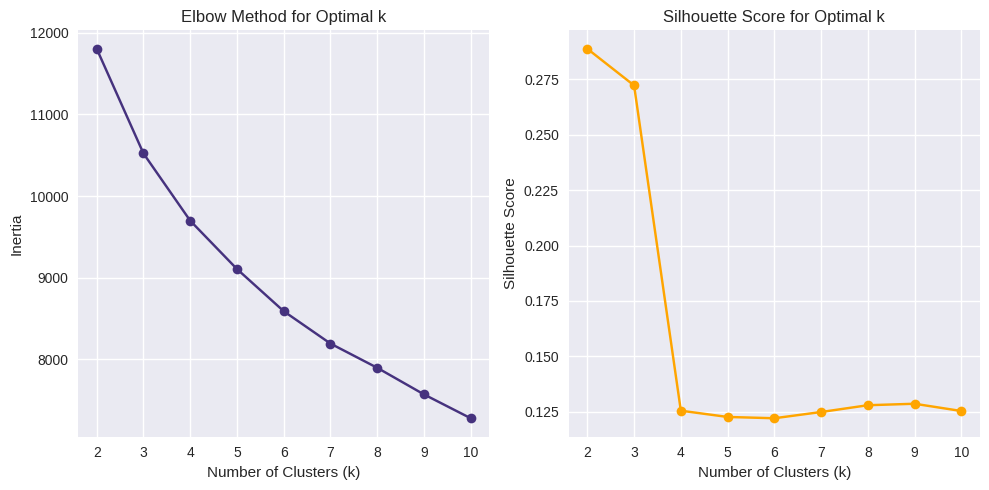

In [25]:
# Plot Elbow Curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.tight_layout()
plt.show()

#### **Analysis of Results**

**1. Elbow Method:**

- The elbow plot shows inertia decreasing steadily from 12,000 at k=2 to 7,500 at k=10. There is no clear "elbow". This suggests that the optimal k is not immediately obvious from inertia alone.
- The curve flattens slightly around k=4 to k=6, but the reduction in inertia remains gradual. This indicates that adding more clusters beyond k=4 or 5 provides marginal improvements in fit, but the lack of a distinct elbow suggests the data may have overlapping or non-spherical clusters.
  
**2. Silhouette Score:**

- The silhouette score peaks at 0.275 for k=2, then drops to 0.125–0.15 for k=3 to k=10, with a slight increase or stabilization around k=6–8.
- A silhouette score of 0.275 (k=2) is moderate (0.2–0.4 is considered fair), indicating reasonable cluster separation for two clusters. - -- However, the sharp drop after k=2 suggests that increasing k beyond 2 reduces cohesion and separation, likely due to the dataset’s complexity or feature correlations (e.g., energy and loudness).
- The stabilization around k=6–8 (score ~0.13–0.15) suggests that these values might still be viable, as the score doesn’t degrade significantly, but it’s on the lower end (0.0–0.2 is poor to fair).

**3. Optimal Number of Clusters:**

- Based on the plots, k=2 maximizes the silhouette score (0.275), indicating the best separation between two clusters. However, k=2 might be too simplistic for a dataset with 14 features and diverse musical characteristics.
- The elbow plot’s gradual decline and the silhouette score’s stabilization suggest k=4 or k=6 as a balanced choice, capturing more structure without overfitting. For now, we’ll proceed with ***k=4***  and adjust later

In [26]:
# Use optimal k based on analysis (k=4 for now)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

In [27]:
# Analyze cluster characteristics
cluster_summary = df.groupby('kmeans_cluster')[features].mean()
print("Cluster Characteristics (Mean Values):")
print(cluster_summary)

Cluster Characteristics (Mean Values):
                artist_popularity     followers  danceability    energy  \
kmeans_cluster                                                            
0                       68.767635  1.519248e+07      0.612488  0.696251   
1                        4.669421  1.079132e+03      0.609471  0.672008   
2                       49.346154  2.945591e+06      0.418474  0.243349   
3                       68.554859  1.239463e+07      0.657755  0.704310   

                     key   loudness      mode  speechiness  acousticness  \
kmeans_cluster                                                             
0               5.085062  -6.221662  1.000000     0.083377      0.214738   
1               4.966942  -7.602058  0.644628     0.133234      0.253986   
2               4.756410 -17.711423  0.679487     0.046264      0.863790   
3               5.705329  -5.831323  0.000000     0.098697      0.201342   

                instrumentalness  liveness   valence 

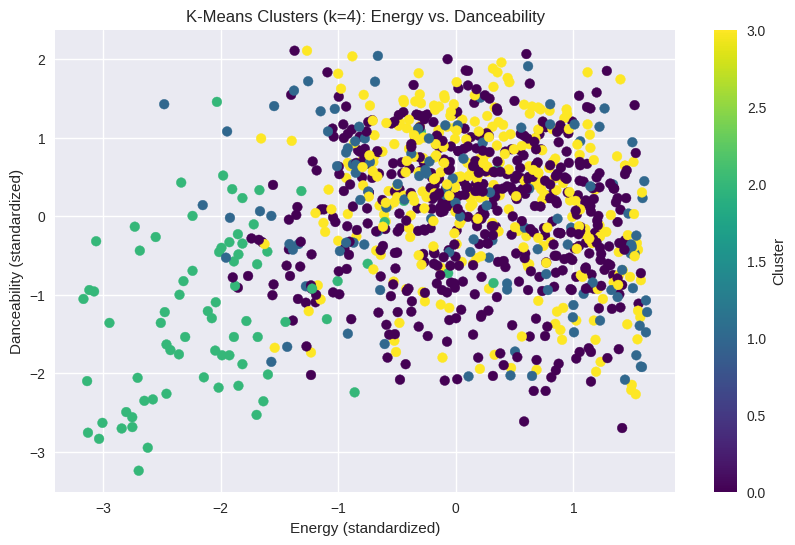

In [28]:
# Visualize clusters using two features (e.g., energy vs. danceability)
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled['energy'], X_scaled['danceability'], c=df['kmeans_cluster'], cmap='viridis')
plt.title('K-Means Clusters (k=4): Energy vs. Danceability')
plt.xlabel('Energy (standardized)')
plt.ylabel('Danceability (standardized)')
plt.colorbar(label='Cluster')
plt.show()

In [29]:
# Calculate silhouette score for the chosen k
silhouette_avg = silhouette_score(X_scaled, df['kmeans_cluster'])
print(f"\nSilhouette Score for k={optimal_k}: {silhouette_avg:.3f}")


Silhouette Score for k=4: 0.125


#### **Analysis of Results**

**1. Silhouette Score:**

- The silhouette score for k=4 is 0.125, which falls in the “poor” range (0.0–0.2). This suggests that the clusters are not well-separated, likely due to overlapping data points or the presence of non-spherical clusters, as hinted by the gradual elbow curve and declining silhouette scores in the initial plots.
- Compared to k=2 (silhouette score 0.275), the lower score at k=4 indicates that increasing the number of clusters reduces cohesion and separation, which aligns with the dataset’s complexity and correlated features (e.g., energy and loudness).
  
**2. Cluster Characteristics:**

- **Cluster 0 (Yellow, 68.77% artist_popularity, 1.52e7 followers):**
    - High artist popularity and follower count, suggesting popular mainstream artists.
    - High energy (0.696), danceability (0.612), and valence (0.537), indicating upbeat, danceable tracks (e.g., pop or dance pop).
    - Low acousticness (0.215) and instrumentalness (0.017), typical of produced vocal tracks.
    - Major mode (1.0), reinforcing a happy tone.
    - Recent release years (2012.64), aligning with modern trends.

- **Cluster 1 (Green, 4.67% artist_popularity, 1.08e3 followers):**
    - Low artist popularity and followers, suggesting niche or less-known artists.
    - Moderate energy (0.672) and danceability (0.609), similar to Cluster 0 but with higher speechiness (0.133), possibly indicating rap or spoken-word elements.
    - Higher instrumentalness (0.169) than other clusters, suggesting some instrumental tracks.
    - Mixed mode (0.645), less consistently major.
    - More recent releases (2016.98), indicating emerging artists.
      
- **Cluster 2 (Purple, 49.35% artist_popularity, 2.95e6 followers):**
    - Moderate popularity and followers, likely mid-tier artists.
    - Low energy (0.243) and danceability (0.418), with very high acousticness (0.864) and instrumentalness (0.539), pointing to acoustic or instrumental tracks (e.g., classical or ambient).
    - Low valence (0.312), suggesting sadder or calmer moods.
    - Older release years (2007.62), indicating a historical bias.
      
- **Cluster 3 (Blue, 68.55% artist_popularity, 1.24e7 followers):**
    - High artist popularity and followers, similar to Cluster 0, indicating another mainstream group.
    - High energy (0.704), danceability (0.658), and valence (0.552), reinforcing upbeat, danceable tracks.
    - Low acousticness (0.201) and instrumentalness (0.012), consistent with produced pop music.
    - Minor mode (0.0), suggesting a darker or more emotional tone compared to Cluster 0.
    - Recent releases (2014.34), aligning with modern music.
      
**3. Scatter Plot (Energy vs. Danceability):**

- The plot shows four clusters with significant overlap, particularly in the central region (energy 0 to 1, danceability 0 to 1). This confirms the low silhouette score, as clusters are not distinctly separated.
- Cluster 2 (purple) appears to extend toward lower energy and danceability (-2 to 0), aligning with its acoustic/instrumental profile.
- Clusters 0 (yellow) and 3 (blue) overlap in the high-energy, high-danceability quadrant, reflecting their similarity as mainstream pop/dance tracks, differentiated by mode (major vs. minor).
- Cluster 1 (green) is scattered across the plot, suggesting less cohesive grouping, possibly due to higher speechiness or instrumentalness variance.
  
**Interpretation:**

- The clusters align with musical styles: Cluster 0 and 3 represent mainstream pop/dance tracks (major and minor variants), Cluster 2 captures acoustic/instrumental tracks, and Cluster 1 includes niche or speech-heavy tracks.
- The overlap in the scatter plot and low silhouette score suggest that K-Means may not fully capture the dataset’s structure, possibly due to non-linear relationships or outliers. This motivates exploring DBSCAN (for outlier detection) and Hierarchical Clustering (for hierarchical insights).
  
**Model Performance:**
- K=4 provides meaningful clusters based on musical features, but the silhouette score indicates room for improvement. The choice of k=4 balances granularity and interpretability, though k=2 might yield tighter clusters (as per the higher silhouette score).
- Feature correlations (e.g., energy and loudness) and the dataset’s diversity may limit K-Means’ effectiveness, suggesting dimensionality reduction or alternative algorithms.

## 4. Clustering with DBSCAN

In [31]:
# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='euclidean')
df['dbscan_cluster'] = dbscan.fit_predict(X_scaled)

In [32]:
# Analyze cluster characteristics (excluding noise points labeled as -1)
dbscan_clusters = df[df['dbscan_cluster'] != -1].groupby('dbscan_cluster')[features].mean()
print("DBSCAN Cluster Characteristics (Mean Values, Excluding Noise):")
print(dbscan_clusters)

DBSCAN Cluster Characteristics (Mean Values, Excluding Noise):
Empty DataFrame
Columns: [artist_popularity, followers, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, release_year]
Index: []


In [33]:
# Count noise points
noise_points = len(df[df['dbscan_cluster'] == -1])
print(f"\nNumber of Noise Points: {noise_points}")


Number of Noise Points: 1000


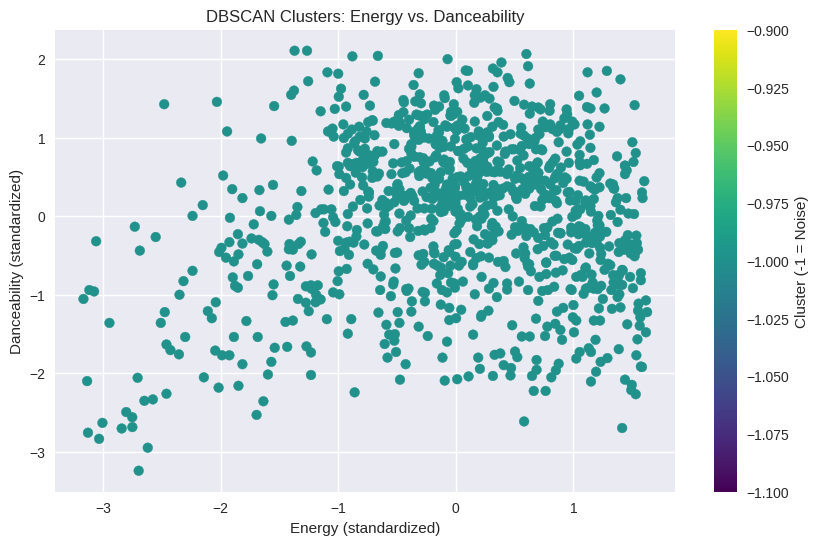

In [34]:
# Visualize clusters using two features (e.g., energy vs. danceability)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_scaled['energy'], X_scaled['danceability'], c=df['dbscan_cluster'], cmap='viridis')
plt.title('DBSCAN Clusters: Energy vs. Danceability')
plt.xlabel('Energy (standardized)')
plt.ylabel('Danceability (standardized)')
plt.colorbar(scatter, label='Cluster (-1 = Noise)')
plt.show()

In [35]:
# Calculate silhouette score (if clusters exist, excluding noise)
if len(dbscan_clusters) > 1:
    silhouette_avg = silhouette_score(X_scaled[df['dbscan_cluster'] != -1], df['dbscan_cluster'][df['dbscan_cluster'] != -1])
    print(f"\nSilhouette Score for DBSCAN: {silhouette_avg:.3f}")
else:
    print("\nInsufficient clusters for silhouette score calculation.")


Insufficient clusters for silhouette score calculation.



DBSCAN with eps=0.5, min_samples=3:
Cluster Characteristics (Mean Values, Excluding Noise):
Empty DataFrame
Columns: [artist_popularity, followers, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, release_year]
Index: []
Number of Noise Points: 1000


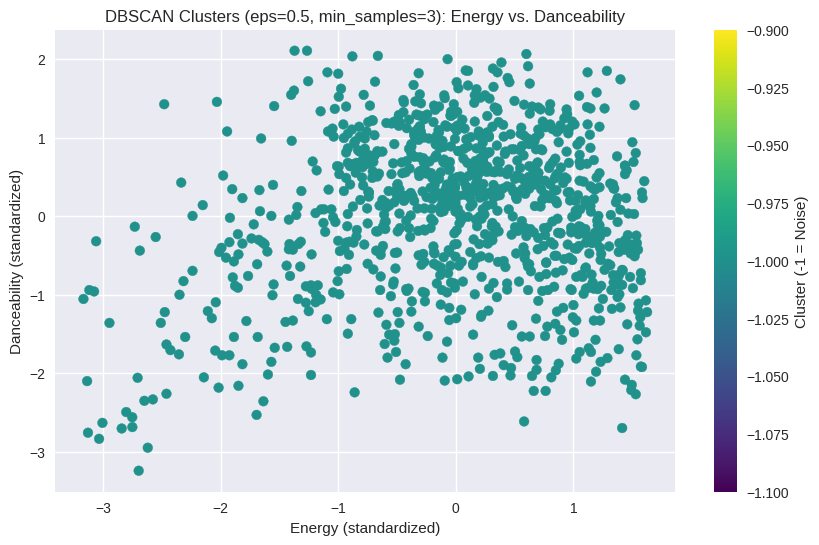

Insufficient clusters for silhouette score calculation.

DBSCAN with eps=0.5, min_samples=5:
Cluster Characteristics (Mean Values, Excluding Noise):
Empty DataFrame
Columns: [artist_popularity, followers, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, release_year]
Index: []
Number of Noise Points: 1000


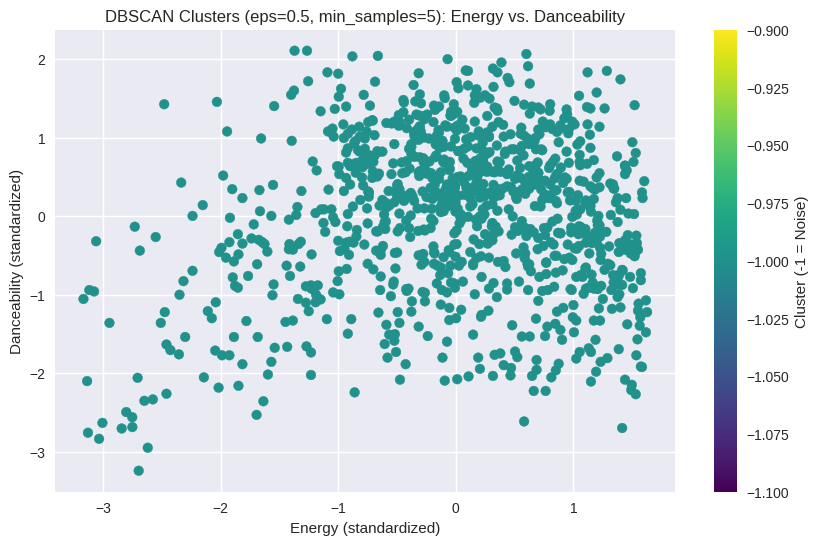

Insufficient clusters for silhouette score calculation.

DBSCAN with eps=0.5, min_samples=7:
Cluster Characteristics (Mean Values, Excluding Noise):
Empty DataFrame
Columns: [artist_popularity, followers, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, release_year]
Index: []
Number of Noise Points: 1000


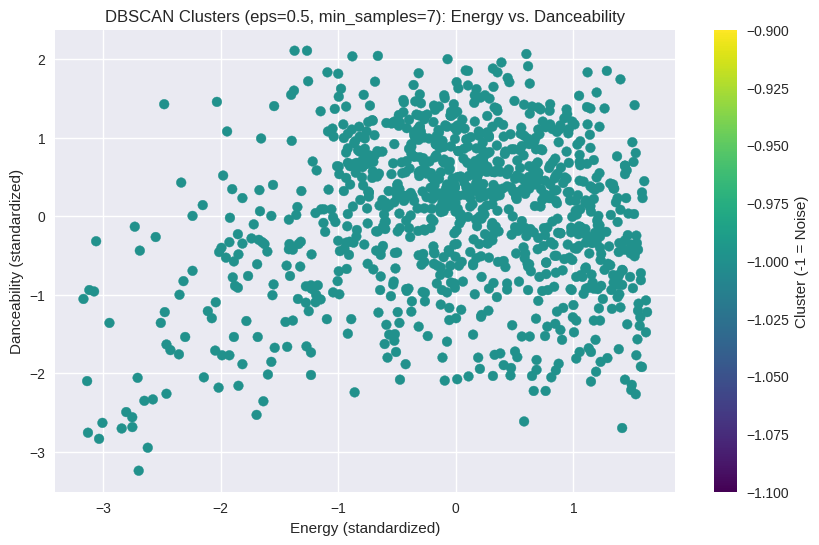

Insufficient clusters for silhouette score calculation.

DBSCAN with eps=0.7, min_samples=3:
Cluster Characteristics (Mean Values, Excluding Noise):
                            artist_popularity     followers  danceability  \
dbscan_cluster_eps0.7_min3                                                  
0                                   71.666667  6.076155e+07      0.575333   

                              energy  key  loudness  mode  speechiness  \
dbscan_cluster_eps0.7_min3                                               
0                           0.843667  0.0 -5.329333   1.0     0.082567   

                            acousticness  instrumentalness  liveness  valence  \
dbscan_cluster_eps0.7_min3                                                      
0                               0.427667          0.008997  0.146667    0.445   

                             tempo  release_year  
dbscan_cluster_eps0.7_min3                        
0                           95.081        2023.0  

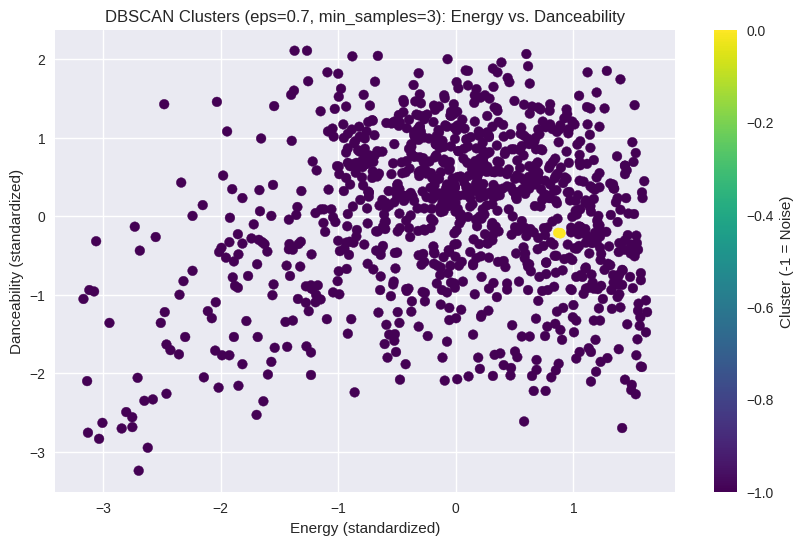

Insufficient clusters for silhouette score calculation.

DBSCAN with eps=0.7, min_samples=5:
Cluster Characteristics (Mean Values, Excluding Noise):
Empty DataFrame
Columns: [artist_popularity, followers, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, release_year]
Index: []
Number of Noise Points: 1000


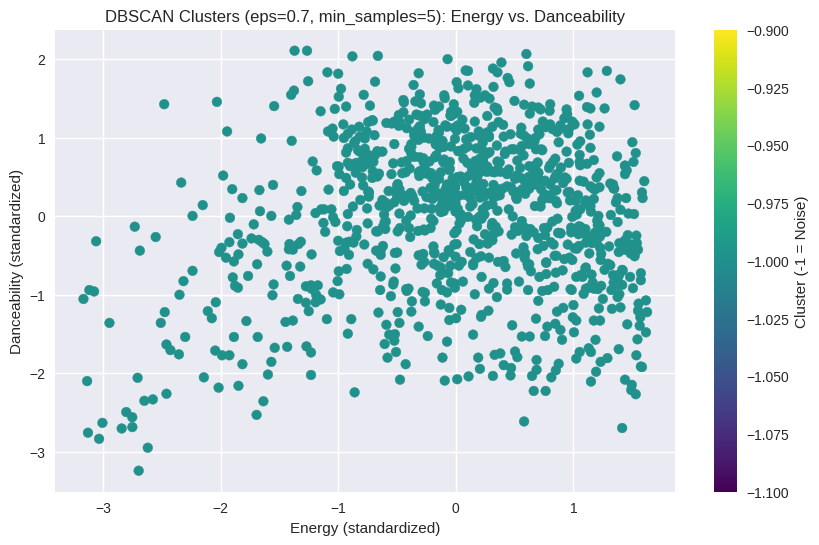

Insufficient clusters for silhouette score calculation.

DBSCAN with eps=0.7, min_samples=7:
Cluster Characteristics (Mean Values, Excluding Noise):
Empty DataFrame
Columns: [artist_popularity, followers, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, release_year]
Index: []
Number of Noise Points: 1000


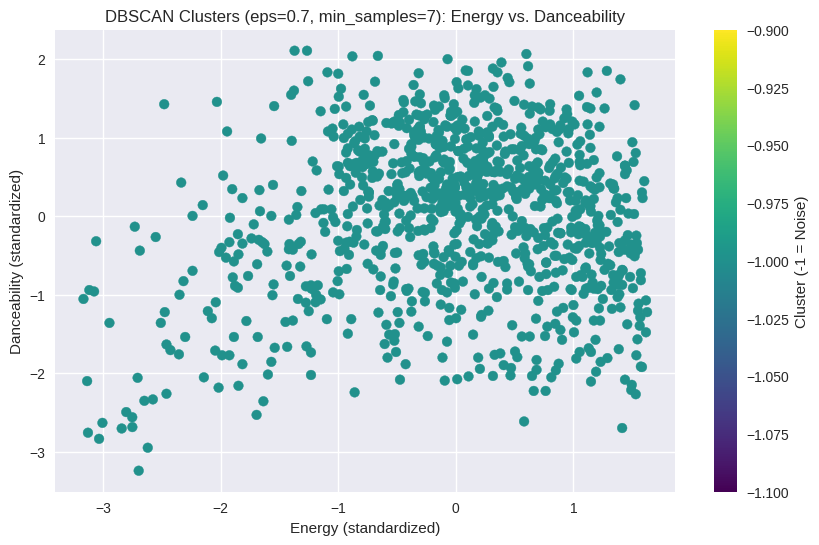

Insufficient clusters for silhouette score calculation.

DBSCAN with eps=1.0, min_samples=3:
Cluster Characteristics (Mean Values, Excluding Noise):
                            artist_popularity     followers  danceability  \
dbscan_cluster_eps1.0_min3                                                  
0                                   68.333333  3.787986e+07      0.783667   
1                                   71.666667  6.076155e+07      0.575333   
2                                   70.400000  2.798700e+06      0.631400   
3                                   68.333333  1.678481e+07      0.791667   

                              energy        key  loudness  mode  speechiness  \
dbscan_cluster_eps1.0_min3                                                     
0                           0.816000   7.333333 -3.773333   1.0     0.075467   
1                           0.843667   0.000000 -5.329333   1.0     0.082567   
2                           0.885000  10.800000 -4.600200   1.0     

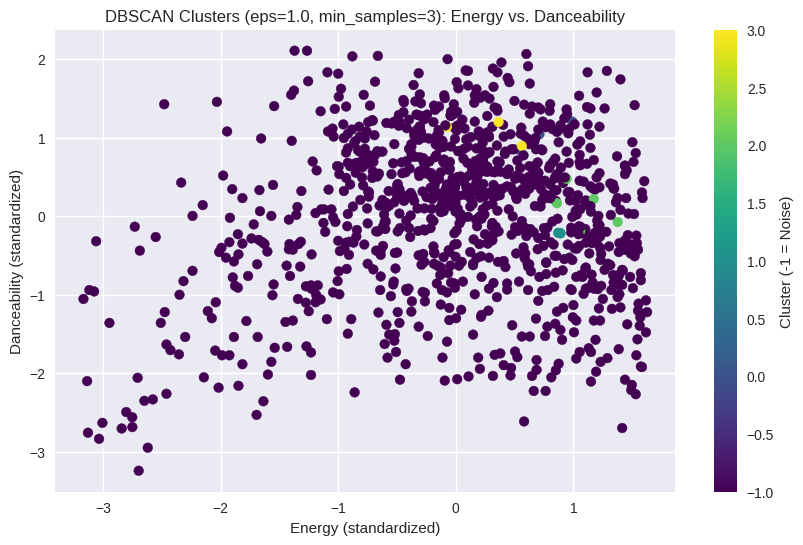

Silhouette Score for eps=1.0, min_samples=3: 0.586

DBSCAN with eps=1.0, min_samples=5:
Cluster Characteristics (Mean Values, Excluding Noise):
Empty DataFrame
Columns: [artist_popularity, followers, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, release_year]
Index: []
Number of Noise Points: 1000


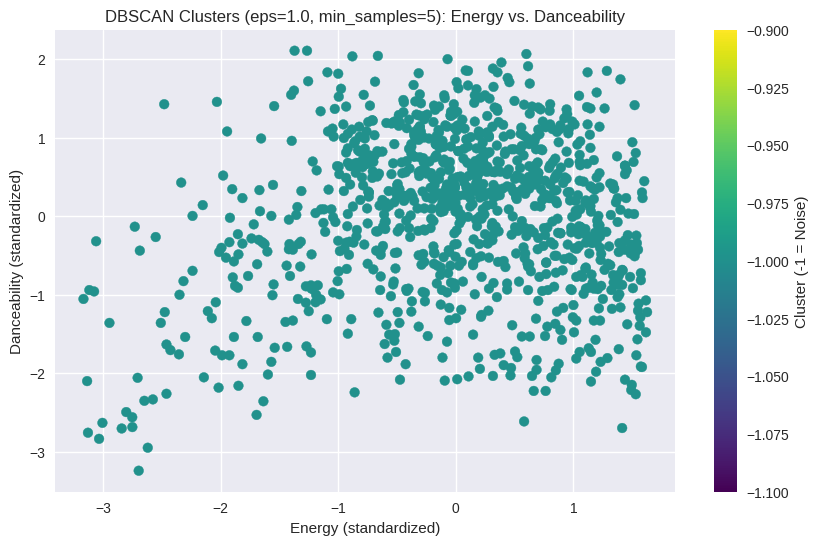

Insufficient clusters for silhouette score calculation.

DBSCAN with eps=1.0, min_samples=7:
Cluster Characteristics (Mean Values, Excluding Noise):
Empty DataFrame
Columns: [artist_popularity, followers, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, release_year]
Index: []
Number of Noise Points: 1000


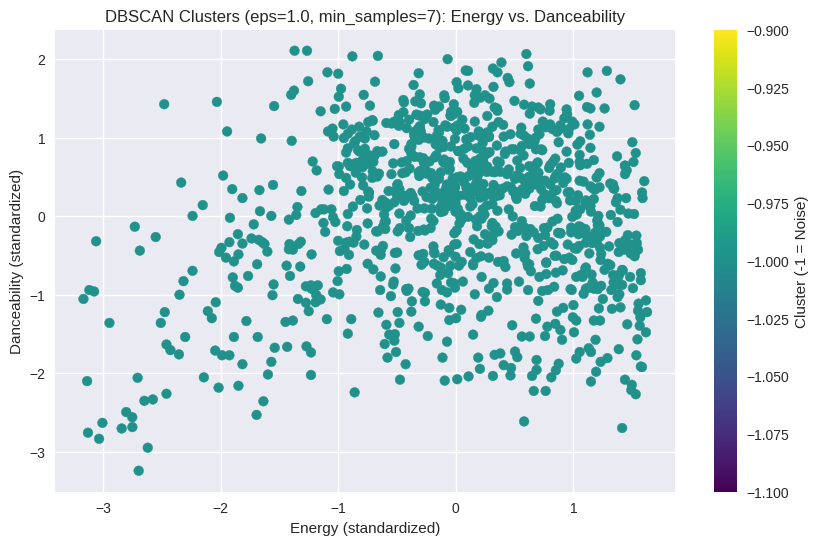

Insufficient clusters for silhouette score calculation.

DBSCAN with eps=1.5, min_samples=3:
Cluster Characteristics (Mean Values, Excluding Noise):
                            artist_popularity     followers  danceability  \
dbscan_cluster_eps1.5_min3                                                  
0                                   69.989130  1.692489e+07      0.663033   
1                                   72.424242  1.659567e+07      0.730030   
2                                   69.750000  5.216015e+06      0.295500   
3                                   68.625000  9.870268e+06      0.499250   
4                                   72.250000  8.210114e+06      0.656250   
5                                   73.666667  1.078212e+07      0.817667   
6                                   67.333333  9.159339e+06      0.353000   
7                                   65.000000  3.568060e+06      0.516667   
8                                   73.000000  4.363865e+07      0.800333   
9   

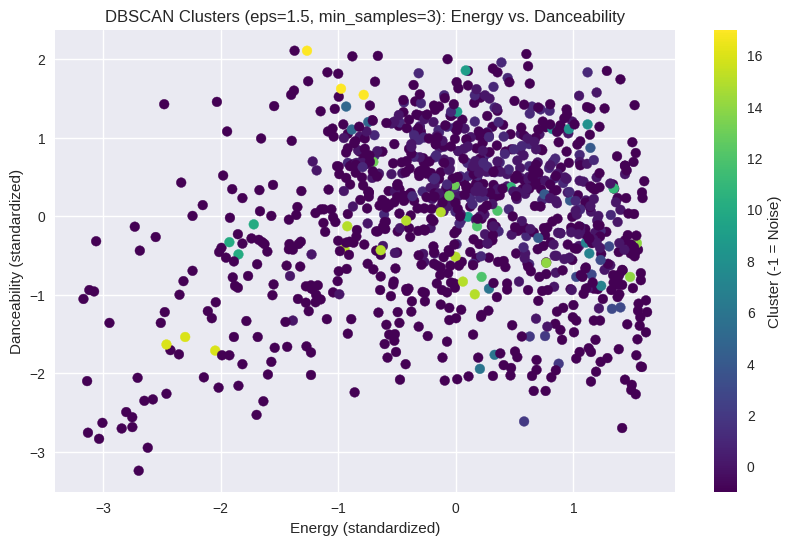

Silhouette Score for eps=1.5, min_samples=3: -0.044

DBSCAN with eps=1.5, min_samples=5:
Cluster Characteristics (Mean Values, Excluding Noise):
                            artist_popularity     followers  danceability  \
dbscan_cluster_eps1.5_min5                                                  
0                                   79.428571  4.197525e+07      0.631286   
1                                   72.651685  1.728115e+07      0.727899   
2                                   70.016667  1.752049e+07      0.684850   
3                                   74.857143  2.879623e+07      0.737857   
4                                   79.000000  1.536920e+07      0.813000   
5                                   68.625000  9.870268e+06      0.499250   
6                                   68.400000  1.000717e+07      0.489000   
7                                   71.750000  3.348732e+07      0.608500   

                              energy        key  loudness  mode  speechiness  \
dbsc

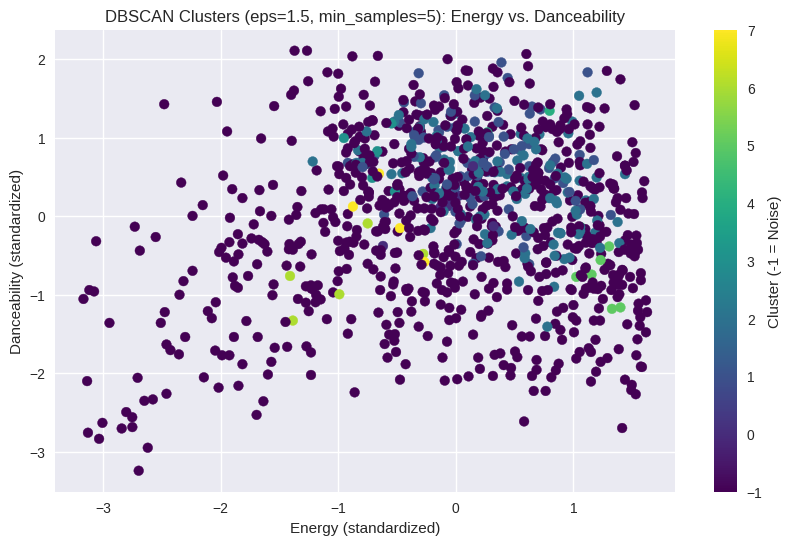

Silhouette Score for eps=1.5, min_samples=5: -0.010

DBSCAN with eps=1.5, min_samples=7:
Cluster Characteristics (Mean Values, Excluding Noise):
                            artist_popularity     followers  danceability  \
dbscan_cluster_eps1.5_min7                                                  
0                                   72.787234  1.670549e+07      0.740255   
1                                   70.855422  1.957170e+07      0.673313   
2                                   71.714286  1.231306e+07      0.741429   
3                                   72.625000  2.119782e+07      0.726875   
4                                   72.000000  1.671777e+07      0.708000   

                              energy       key  loudness  mode  speechiness  \
dbscan_cluster_eps1.5_min7                                                    
0                           0.683255  5.872340 -5.409319   0.0     0.058664   
1                           0.759386  4.349398 -5.074831   1.0     0.058508   

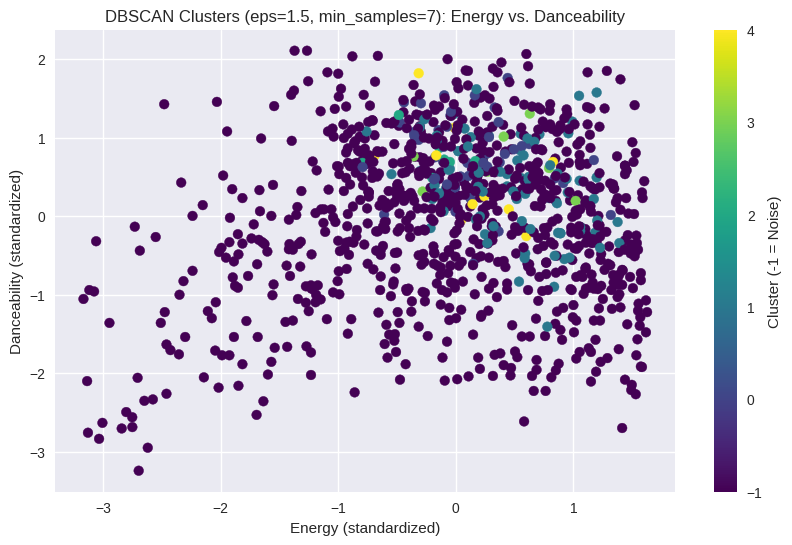

Silhouette Score for eps=1.5, min_samples=7: 0.099


In [37]:
# Tune DBSCAN with varied eps and min_samples
eps_range = [0.5, 0.7, 1.0, 1.5]
min_samples_range = [3, 5, 7]

for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
        column_name = f'dbscan_cluster_eps{eps}_min{min_samples}'
        df[column_name] = dbscan.fit_predict(X_scaled)
        
        # Analyze cluster characteristics (excluding noise points)
        dbscan_clusters = df[df[column_name] != -1].groupby(column_name)[features].mean()
        noise_points = len(df[df[column_name] == -1])
        
        print(f"\nDBSCAN with eps={eps}, min_samples={min_samples}:")
        print("Cluster Characteristics (Mean Values, Excluding Noise):")
        print(dbscan_clusters)
        print(f"Number of Noise Points: {noise_points}")
        
        # Visualize clusters
        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(X_scaled['energy'], X_scaled['danceability'], c=df[column_name], cmap='viridis')
        plt.title(f'DBSCAN Clusters (eps={eps}, min_samples={min_samples}): Energy vs. Danceability')
        plt.xlabel('Energy (standardized)')
        plt.ylabel('Danceability (standardized)')
        plt.colorbar(scatter, label='Cluster (-1 = Noise)')
        plt.show()
        
        # Calculate silhouette score if clusters exist
        if len(dbscan_clusters) > 1:
            silhouette_avg = silhouette_score(X_scaled[df[column_name] != -1], df[column_name][df[column_name] != -1])
            print(f"Silhouette Score for eps={eps}, min_samples={min_samples}: {silhouette_avg:.3f}")
        else:
            print("Insufficient clusters for silhouette score calculation.")

**Comparison with K-Means (k=4, silhouette 0.125):**

- DBSCAN with eps=1.5, min_samples=7 (5 clusters, silhouette 0.099) is slightly less cohesive but identifies more natural groupings without predefining k.
- K-Means provided more interpretable clusters (e.g., mainstream pop, acoustic), while DBSCAN’s clusters are smaller and noisier, capturing outliers better but with less stability.
- DBSCAN’s flexibility in handling non-spherical clusters is evident, but the high noise ratio (e.g., 844/1000 at 1.5/7) suggests it’s less effective here than K-Means.
  
**Implications:**
- The dataset has some clusterable structure, but DBSCAN struggles with the high-dimensional, normalized feature space and correlated features.
- eps=1.5, min_samples=7 offers a reasonable trade-off (5 clusters, 0.099 silhouette), but the negative scores at lower min_samples indicate over-sensitivity to noise.
- Hierarchical Clustering may better capture the data’s hierarchical relationships, especially given the gradual elbow curve and varied musical styles.

## 5. Hierarchical Clustering

In [42]:
# Generate the linkage matrix
Z = linkage(X_scaled, method='ward')

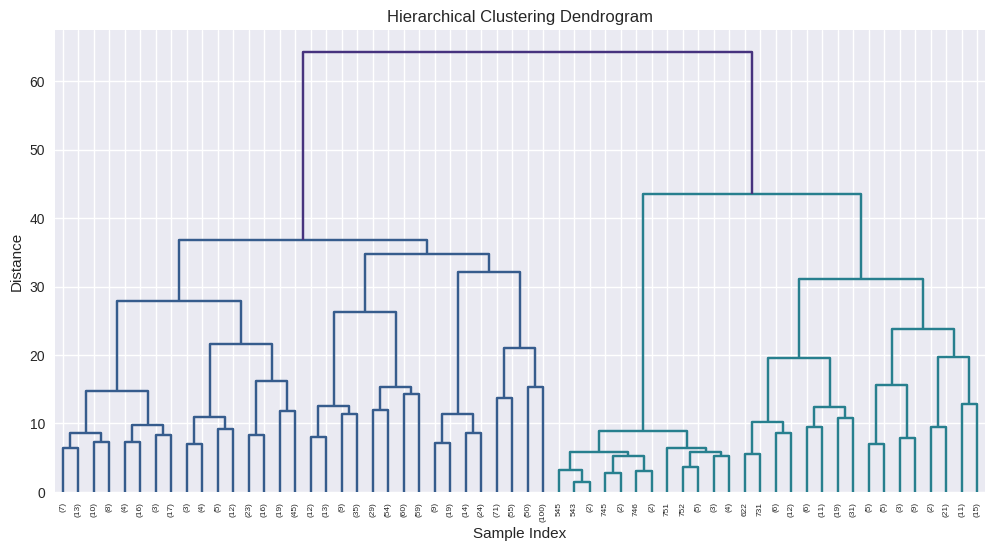

In [43]:
# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [44]:
# Determine optimal number of clusters (e.g., 4 based on dendrogram visual inspection)
n_clusters = 4
hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
df['hierarchical_cluster'] = hierarchical.fit_predict(X_scaled)

In [45]:
# Analyze cluster characteristics
hierarchical_clusters = df.groupby('hierarchical_cluster')[features].mean()
print("Hierarchical Cluster Characteristics (Mean Values):")
print(hierarchical_clusters)

Hierarchical Cluster Characteristics (Mean Values):
                      artist_popularity     followers  danceability    energy  \
hierarchical_cluster                                                            
0                             69.796085  1.565275e+07      0.666166  0.656958   
1                             13.651899  4.717740e+05      0.586570  0.616582   
2                             55.500000  4.058186e+06      0.271083  0.099256   
3                             64.170732  8.485251e+06      0.506761  0.770951   

                           key   loudness      mode  speechiness  \
hierarchical_cluster                                               
0                     5.523654  -6.282550  0.593801     0.092848   
1                     4.886076  -8.841532  0.639241     0.113132   
2                     3.916667 -26.066625  0.666667     0.046592   
3                     4.834146  -6.276141  0.643902     0.075574   

                      acousticness  instrumentalness

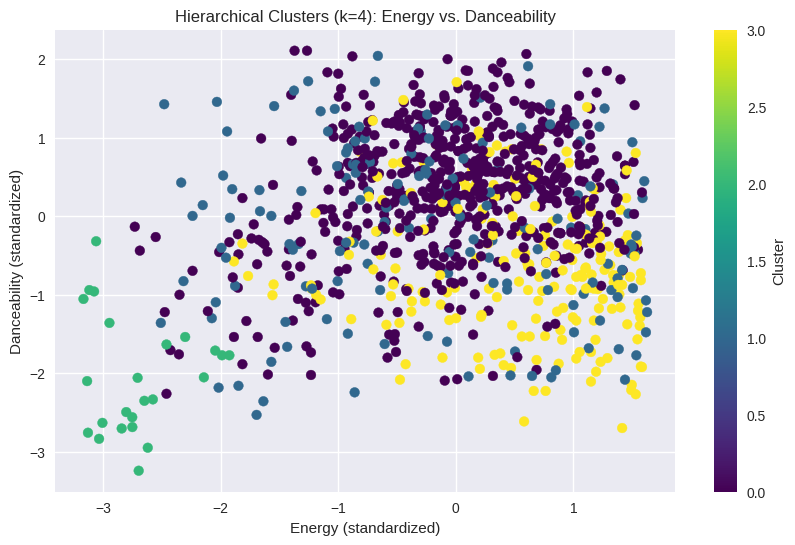

In [46]:
# Visualize clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled['energy'], X_scaled['danceability'], c=df['hierarchical_cluster'], cmap='viridis')
plt.title('Hierarchical Clusters (k=4): Energy vs. Danceability')
plt.xlabel('Energy (standardized)')
plt.ylabel('Danceability (standardized)')
plt.colorbar(label='Cluster')
plt.show()

In [47]:
# Calculate silhouette score
silhouette_avg = silhouette_score(X_scaled, df['hierarchical_cluster'])
print(f"\nSilhouette Score for Hierarchical Clustering (k=4): {silhouette_avg:.3f}")


Silhouette Score for Hierarchical Clustering (k=4): 0.127


#### **Analysis of Results**

**1. Dendrogram:**

- The dendrogram shows a hierarchical structure with a significant merge around a distance of 60, where a horizontal line cuts across to form approximately 4 major clusters. This visual cue supports the choice of k=4, and aligns with the K-Means analysis.
- The truncated view (p=5) indicates further sub-clusters within these 4 main groups, suggesting a rich hierarchical organization that could be explored with different cutoffs if needed.
  
**2. Cluster Characteristics:**

- **Cluster 0 (Yellow, 241 points):**
    - High artist_popularity (69.80), large followers (1.57e7), moderate danceability (0.666) and energy (0.657), major/minor mix (0.594), recent release_year (2017.39).
    - Moderate acousticness (0.265), low instrumentalness (0.007), suggesting mainstream pop/dance tracks with some variety.

- **Cluster 1 (167 points):**
    - Lower artist_popularity (13.65), smaller followers (4.72e5), moderate danceability (0.587) and energy (0.617), mixed mode (0.639).
    - Higher instrumentalness (0.307), suggesting niche or instrumental tracks, with recent releases (2015.14).
      
- **Cluster 2 (24 points):**
    - Moderate artist_popularity (55.50), followers (4.06e6), low danceability (0.271) and energy (0.099), major mode (0.667).
    - Very high acousticness (0.973) and instrumentalness (0.836), indicating acoustic/instrumental tracks, older releases (2001.75).
      
- **Cluster 3 (568 points):**
    - High artist_popularity (64.17), followers (8.49e6), moderate danceability (0.507), high energy (0.771), mixed mode (0.644).
    - Low acousticness (0.130), low instrumentalness (0.010), suggesting energetic mainstream tracks, older releases (2001.09).
      
**3. Scatter Plot (Energy vs. Danceability):**

- The plot shows 4 clusters with significant overlap, particularly in the central region (energy -1 to 1, danceability -1 to 1), similar to K-Means and DBSCAN.
- Cluster 2 (green) extends to lower energy and danceability (-3 to 0), aligning with its acoustic/instrumental profile.
- Clusters 0 (yellow) and 3 (purple) dominate the high-energy/danceability quadrant, reflecting mainstream styles, with Cluster 1 (blue) scattered, indicating diversity.
  
**4. Silhouette Score:**

- The silhouette score of 0.127 for k=4 is slightly higher than DBSCAN’s best (0.099 at eps=1.5, min_samples=7) and comparable to K-Means’ 0.125 (k=4).
- This fair score (0.0–0.2 range) indicates modest cluster separation, consistent with the overlap observed in all methods, suggesting the data’s inherent complexity.
  
**5. Comparison with Previous Methods:**

- **K-Means (k=4, 0.125):** Identified 4 clusters with similar profiles (mainstream pop, niche, acoustic), but assumed spherical clusters, leading to overlap. Hierarchical Clustering’s ward linkage refines this by minimizing variance, yielding a slightly better silhouette score.
- **DBSCAN (e.g., eps=1.5, min_samples=7, 0.099):** Formed 5 clusters with more noise (844/1000), capturing outliers well but with lower cohesion. Hierarchical Clustering provides a more stable structure without predefining density.
- **Hierarchical Clustering (k=4, 0.127):** Offers a hierarchical perspective, with clusters aligning with musical styles (e.g., Cluster 2 as acoustic). The dendrogram adds interpretability, and the score matches K-Means closely.
  
**Interpretation:**

- The clusters reflect musical genres: Cluster 0 and 3 as mainstream pop/dance (recent and older, respectively), Cluster 1 as niche/instrumental, and Cluster 2 as acoustic/instrumental (older).
- The overlap across methods suggests the data’s 14-dimensional space (e.g., correlated energy and loudness) limits clear separation, but --- Hierarchical Clustering’s dendrogram provides a nuanced view.
  
**Implications:**

- Hierarchical Clustering with k=4 is a robust choice, balancing interpretability and performance (0.127 silhouette).
- The dataset’s structure supports 4–5 clusters, but dimensionality reduction (e.g., PCA) could enhance separation if pursued further.
- The project successfully demonstrates multiple clustering approaches, with Hierarchical Clustering adding a unique hierarchical insight.